In [ ]:
import sys 
!{sys.executable} -m pip install --user lime

In [1]:
## for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition## for explainer
from lime import lime_tabular

In [2]:
sat_id = 1
train = pd.read_csv('df_jan_train.csv', engine='python')
dtf_train = train[train.sat_id==sat_id].copy()
dtf_train['epoch'] = pd.to_datetime(dtf_train['epoch'], infer_datetime_format=True)
dtf_train['epoch'] = dtf_train['epoch'].dt.strftime('%Y-%m-%d %H:%M:%S')
dtf_train.head(2)

sat_id                epoch        date  day  hour  minute             x  \
0       1  2014-01-01 00:00:00  2014-01-01    1     0       0  10390.313089   
1       1  2014-01-01 00:21:11  2014-01-01    1     0      21  11195.606833   

             y            z               next_epoch  time_diff        next_x  \
0 -2796.458271  3179.562085  2014-01-01 00:21:11.845  21.197417  11195.606833   
1  5078.653968  -839.076593  2014-01-01 00:42:23.690  21.197417   8235.556436   

         next_y       next_z  
0   5078.653968  -839.076593  
1  11445.904263 -4680.514023

In [3]:
cols = ['x','y','z','time_diff','next_x','next_y','next_z']
dtf_train = dtf_train[cols]
dtf_train.head(2)

x            y            z  time_diff        next_x  \
0  10390.313089 -2796.458271  3179.562085  21.197417  11195.606833   
1  11195.606833  5078.653968  -839.076593  21.197417   8235.556436   

         next_y       next_z  
0   5078.653968  -839.076593  
1  11445.904263 -4680.514023

In [4]:
dtf_train.time_diff.describe()

count    1630.000000
mean       21.197413
std         0.000007
min        21.197400
25%        21.197417
50%        21.197417
75%        21.197417
max        21.197433
Name: time_diff, dtype: float64

In [5]:
def get_xy(df, target_col):

    target_cols = ['next_x','next_y','next_z']
    X = df.drop(target_cols, axis=1).values
    y = df[target_col].values
    feature_names = df.drop(target_cols, axis=1).columns.tolist()
    return X, y, feature_names

target_col = 'next_x'
X, y, feature_names = get_xy(dtf_train, target_col)

In [6]:
## Call model
model = ensemble.GradientBoostingRegressor()

## Importance
model.fit(X,y)
importances = model.feature_importances_

## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
                                "VARIABLE":feature_names}).sort_values("IMPORTANCE",ascending=False)


dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


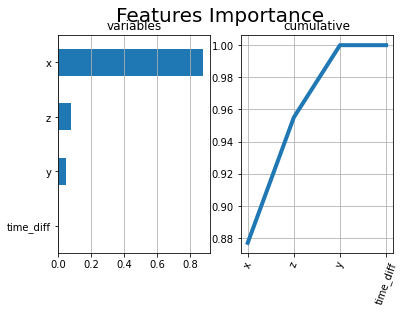

In [7]:
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

In [8]:
X_names = ['x','y','z','time_diff']
X_train = dtf_train[X_names].values
y_train = dtf_train[target_col].values

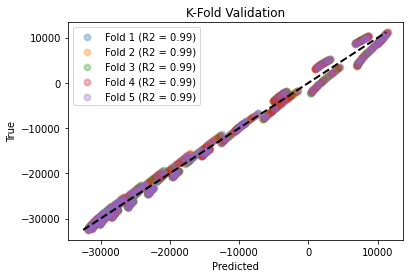

In [9]:
## call model
model = linear_model.LinearRegression()

## K fold validation
scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

In [10]:
## train
model.fit(X_train, y_train)

## test
X_test = X_train
y_test = y_train
predicted = model.predict(X_test)

In [11]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predicted)/predicted)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))

## residuals
residuals = y_test - predicted
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], predicted[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.99
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.19
Mean Absolute Error (Σ|y-pred|/n): 911
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 1,104
Max Error: -3,159


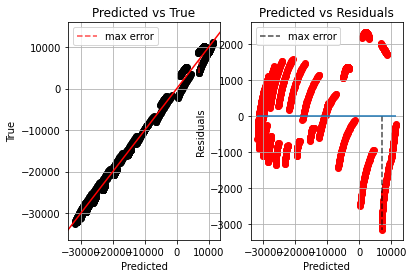

In [12]:
## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2)
from statsmodels.graphics.api import abline_plot
ax[0].scatter(predicted, y_test, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
## Plot predicted vs residuals
ax[1].scatter(predicted, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
ax[1].legend()
plt.show()

/Users/avillamonte/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


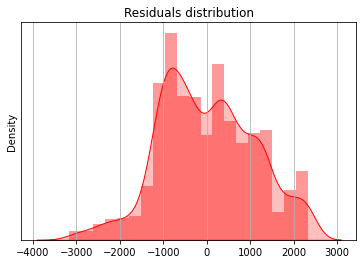

In [13]:
fig, ax = plt.subplots()
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(yticks=[], yticklabels=[], title="Residuals distribution")
plt.show()

In [50]:
dtf_train[cols]

x             y            z  time_diff
0     10390.313089  -2796.458271  3179.562085  21.197417
1     11195.606833   5078.653968  -839.076593  21.197417
2      8235.556436  11445.904263 -4680.514023  21.197400
3      3560.149776  15634.195146 -7654.177182  21.197417
4     -1580.476891  18023.318335 -9755.287599  21.197417
...            ...           ...          ...        ...
1625 -27490.048138  -8518.886959  3567.795848  21.197417
1626 -24519.549871 -10506.379362  5148.977399  21.197417
1627 -20759.732473 -12151.158885  6561.768045  21.197400
1628 -16136.197932 -13281.770411  7696.100376  21.197417
1629 -10574.767362 -13620.363209  8369.860881  21.197417

[1630 rows x 4 columns]

In [46]:
import math
cols = ['x','y','z','time_diff']
aux = dtf_train[cols].iloc[1:2,:].copy()
n = math.floor(aux.time_diff.max())
aux = pd.DataFrame(np.repeat(aux.values, n+1, axis=0))
aux.columns = cols
for i in range(0,n):
    aux.loc[i,'time_diff'] = aux.loc[i,'time_diff'] + (i-n)
    #aux.loc[i,'time_diff'] = math.floor(aux.loc[i,'time_diff'] + (i-n+1))
aux.head(30)

x            y           z  time_diff
0   11195.606833  5078.653968 -839.076593   0.197417
1   11195.606833  5078.653968 -839.076593   1.197417
2   11195.606833  5078.653968 -839.076593   2.197417
3   11195.606833  5078.653968 -839.076593   3.197417
4   11195.606833  5078.653968 -839.076593   4.197417
5   11195.606833  5078.653968 -839.076593   5.197417
6   11195.606833  5078.653968 -839.076593   6.197417
7   11195.606833  5078.653968 -839.076593   7.197417
8   11195.606833  5078.653968 -839.076593   8.197417
9   11195.606833  5078.653968 -839.076593   9.197417
10  11195.606833  5078.653968 -839.076593  10.197417
11  11195.606833  5078.653968 -839.076593  11.197417
12  11195.606833  5078.653968 -839.076593  12.197417
13  11195.606833  5078.653968 -839.076593  13.197417
14  11195.606833  5078.653968 -839.076593  14.197417
15  11195.606833  5078.653968 -839.076593  15.197417
16  11195.606833  5078.653968 -839.076593  16.197417
17  11195.606833  5078.653968 -839.076593  17.197417
18  11195.606833  5078.653968 -839.076593  18.197417
19  11195.606833  5078.653968 -839.076593  19.197417
20  11195.606833  5078.653968 -839.076593  20.197417
21  11195.606833  5078.653968 -839.076593  21.197417

In [49]:
model.predict(aux.values)[:10]

array([10245123.73375003,  9757713.74887764,  9270303.76400526,
        8782893.77913287,  8295483.79426049,  7808073.8093881 ,
        7320663.82451571,  6833253.83964332,  6345843.85477094,
        5858433.86989855])

In [ ]:
pd.DataFrame(predicted, columns=[target_col]).to_csv(f'pred_{sat_id}_{target_col}.csv', index=False)

In [ ]:
aux = pd.DataFrame(X_test, columns=['x','y','z','time_diff'])
print(aux['time_diff'].min()*-1,aux['time_diff'].max())
aux['rand'] = np.random.randint(aux['time_diff'].min()*-1,aux['time_diff'].max(),(len(aux), 1))
aux['time_diff'] = aux['time_diff'] + aux['rand']
aux.drop(columns=['rand'], inplace=True)

In [ ]:
model.predict(aux)

In [ ]:
#aux['rand'] = np.random.randint(0,aux['x'].max(),(len(aux), 1))
#aux['x'] = aux['x'] + aux['rand']
#aux.drop(columns=['rand'], inplace=True)